## Pre-processing Cellranger outputs

This notebook demonstrates the pipeline for processing scRNA-seq data, covering metric computation, normalization, clustering, cell type prediction, and the identification/removal of doublets and low-quality clusters. The final output is pre-processed, annotated scRNA-seq data.

In [1]:
path = '/home/vas744/Analysis/Python/Packages/PIASO'
import sys
sys.path.append(path)
import piaso

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
from typing import Iterable, Union, Optional
import matplotlib.pyplot as plt
import anndata as ad
from scipy import sparse
import logging
from matplotlib import rcParams
import seaborn as sns
from matplotlib import cm
from matplotlib import colors, colorbar
from sklearn.preprocessing import StandardScaler
import warnings
import cosg

# To modify the default figure size, use rcParams.
rcParams['figure.figsize'] = 4, 4
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "Arial"
sc.settings.verbosity = 3
sc.logging.print_header()
sc.set_figure_params(dpi=80,dpi_save=300, color_map='viridis',facecolor='white')

scanpy==1.10.3 anndata==0.10.8 umap==0.5.7 numpy==1.26.4 scipy==1.12.0 pandas==2.2.3 scikit-learn==1.5.2 statsmodels==0.14.4 igraph==0.11.8 louvain==0.8.2 pynndescent==0.5.13


In [3]:
warnings.simplefilter(action='ignore', category=FutureWarning)

### Load the data

The dataset used in this tutorial was obtained from: https://www.10xgenomics.com/datasets/10k-Mouse-Brain-CNIK-3p-gemx

In [4]:
save_dir = '/n/scratch/users/v/vas744/Results/PIASO_Testing/'

In [5]:
data_path = "/n/scratch/users/v/vas744/Data/Public/PIASO/10k_Mouse_Brain_CNIK_3p_gemx_10k_Mouse_Brain_CNIK_3p_gemx_count_sample_filtered_feature_bc_matrix.h5"

adata=sc.read_10x_h5(data_path)

reading /n/scratch/users/v/vas744/Data/Public/PIASO/10k_Mouse_Brain_CNIK_3p_gemx_10k_Mouse_Brain_CNIK_3p_gemx_count_sample_filtered_feature_bc_matrix.h5
 (0:00:02)


/home/vas744/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/vas744/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [6]:
adata

AnnData object with n_obs × n_vars = 11357 × 33696
    var: 'gene_ids', 'feature_types', 'genome'

In [7]:
adata.layers['raw']=adata.X.copy()

In [8]:
adata.var_names_make_unique()

This dataset contains a single sample, but we will add a Sample column to adata.obs and assign a sample name to facilitate downstream analysis.

In [9]:
adata.obs['Sample'] = 'MouseBrain3primeV4'

Next, we filter out cells with fewer than 200 detected genes.

In [10]:
sc.pp.filter_cells(adata, min_genes=200)

We identify mitochondrial and ribosomal protein genes and compute their proportion in each cell’s total read count. A high proportion of these reads often indicates low-quality cells.

In [11]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [12]:
ribo_cells = adata.var_names.str.startswith('Rps','Rpl')
adata.obs['pct_counts_ribo'] = np.ravel(100*np.sum(adata[:, ribo_cells].X, axis = 1) / np.sum(adata.X, axis = 1))

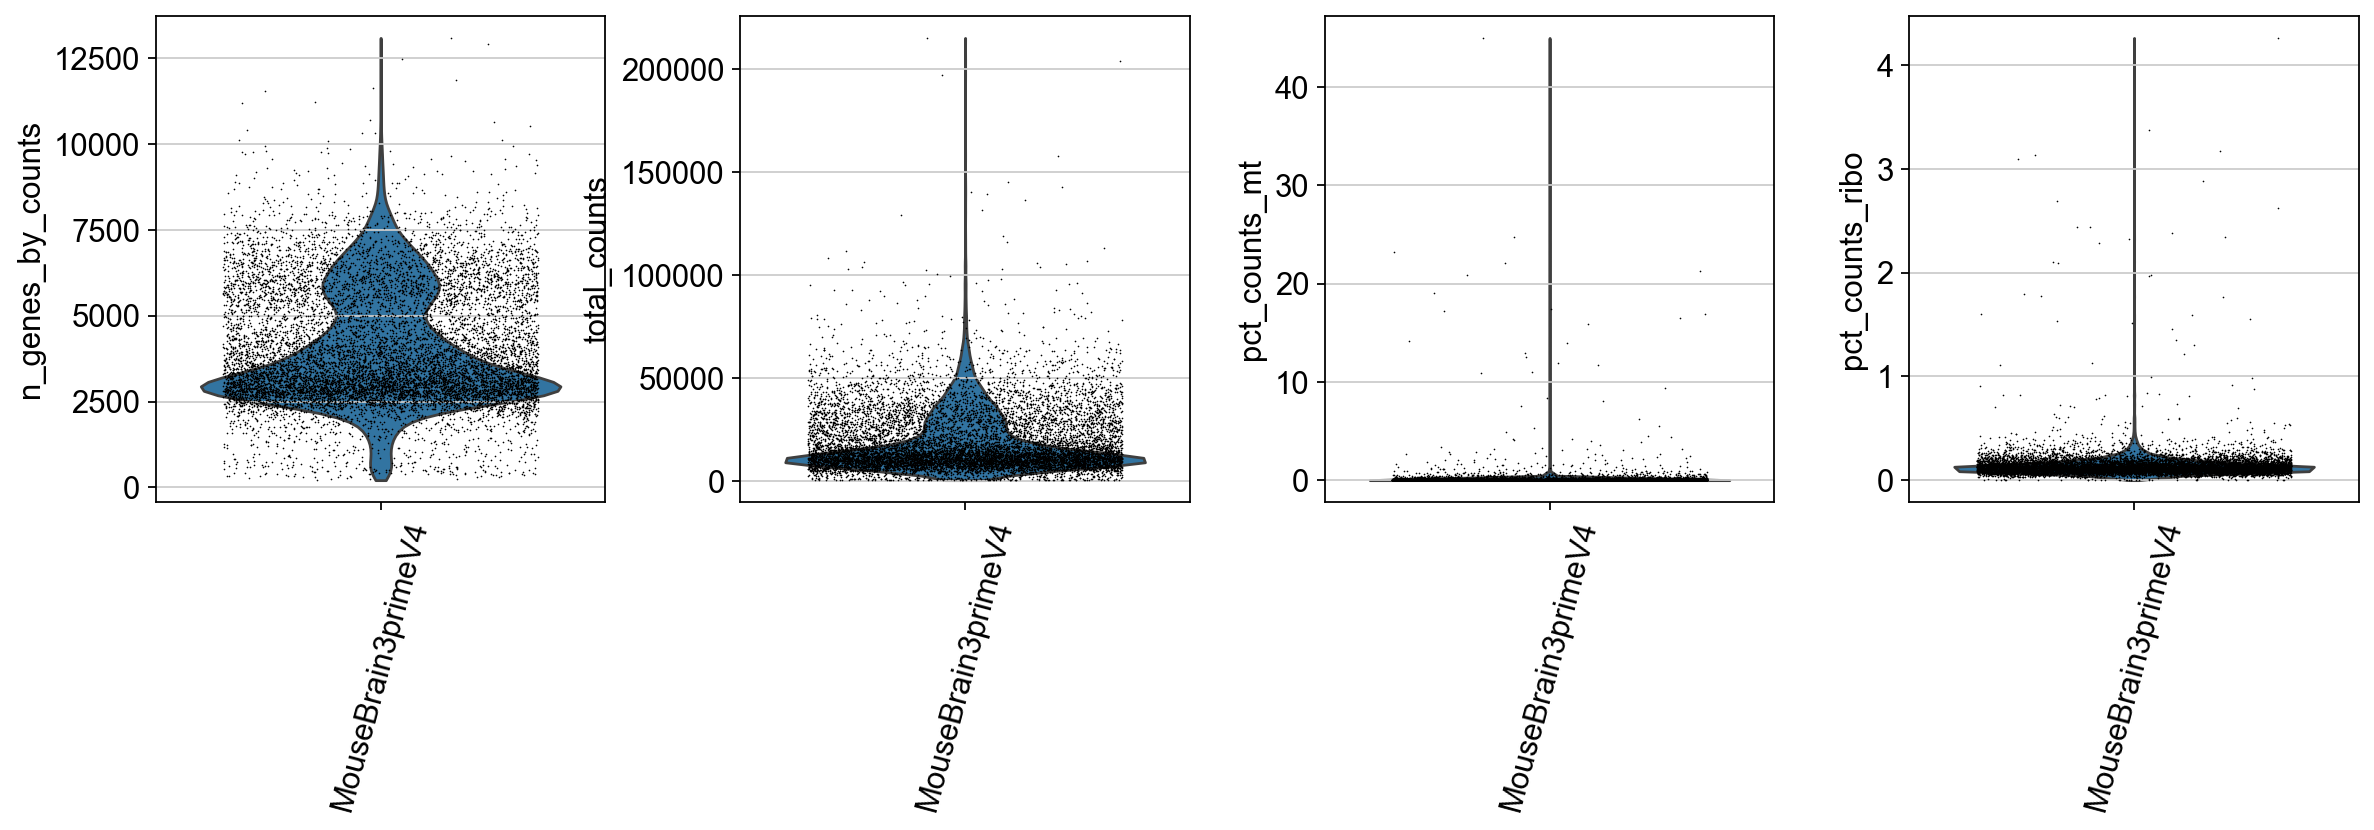

In [13]:
sc.pl.violin(adata,
             ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo'],
             groupby='Sample',
             rotation=75,
             jitter=0.35,
             multi_panel=True,
             size = 0.75)

### Doublet prediction

Next, we compute the Scrublet score to identify and predict potential doublets.

In [14]:
experiments=np.unique(adata.obs['Sample'])
adata.obs['scrublet_score']=np.repeat(0,adata.n_obs)
adata.obs['predicted_doublets']=np.repeat(False,adata.n_obs)

In [15]:
import scrublet as scr

for experiment in experiments:
    print(experiment)
    adatai=adata[adata.obs['Sample']==experiment]

    scrub = scr.Scrublet(adatai.X.todense(),random_state=10)
    doublet_scores, predicted_doublets = scrub.scrub_doublets()
    
    adata.obs['predicted_doublets'][adatai.obs_names]=predicted_doublets
    
    adata.obs['scrublet_score'][adatai.obs_names]=doublet_scores    

MouseBrain3primeV4
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.30
Detected doublet rate = 5.8%
Estimated detectable doublet fraction = 62.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 9.2%
Elapsed time: 71.0 seconds


/tmp/ipykernel_4133/2312138584.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['predicted_doublets'][adatai.obs_names]=predicted_doublets
/tmp/ipykernel_4133/2312138584.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['scrublet_score'][adatai.obs_names]=doublet_scores


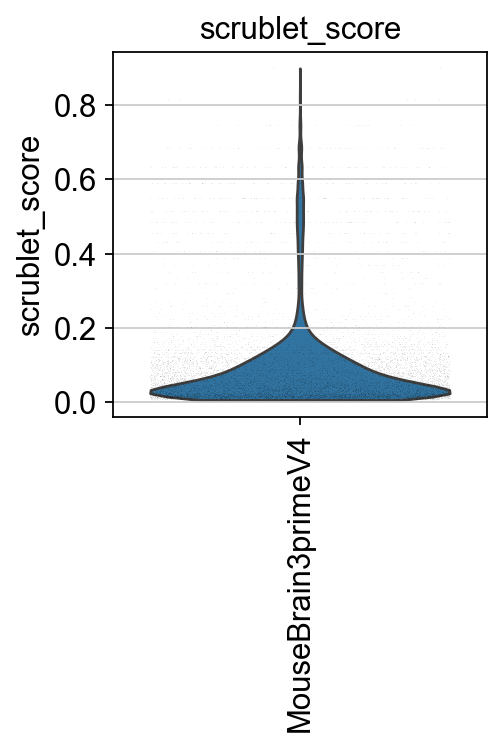

In [16]:
piaso.pl.plot_features_violin(adata,
                              ['scrublet_score'],
                              groupby='Sample',
                              width_single=3,
                              height_single=3)

In [17]:
tmp=np.repeat(False, adata.n_obs)
tmp[adata.obs['predicted_doublets'].values==True]=True
adata.obs['predicted_doublets']=tmp

In [18]:
print(f"# of cells with scrublet score >= 0.2: {np.sum(adata.obs['scrublet_score']>=0.2)} \n# of predicted doublets: {np.sum(adata.obs['predicted_doublets'])}")

# of cells with scrublet score >= 0.2: 874 
# of predicted doublets: 657


### Normalization

In [19]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

adata.layers['log1p']=adata.X.copy()

normalizing counts per cell
    finished (0:00:00)


### INFOG normalization

We use PIASO's infog to normalize the data and identify a highly variable set of genes.

In [20]:
%%time
piaso.tl.infog(adata,
               layer='raw',
               n_top_genes=3000,)

/home/vas744/Analysis/Python/Packages/PIASO/piaso/tools/_normalization.py:85: RuntimeWarning: divide by zero encountered in divide
  info_factor=sparse.diags(counts_sum/cell_depth.ravel()) @ counts @ sparse.diags(1/gene_depth.ravel())


The normalized data is saved as `infog` in `adata.layers`.
The highly variable genes are saved as `highly_variable` in `adata.obs`.
Finished INFOG normalization.
CPU times: user 3.29 s, sys: 2.09 s, total: 5.38 s
Wall time: 5.38 s


### SVD Dimensionality reduction and visualization

In [21]:
piaso.tl.runSVD(adata,
                use_highly_variable=True,
                n_components=50,
                random_state=10,
                key_added='X_svd',
                layer='infog')

In [22]:
%%time
sc.pp.neighbors(adata,
                use_rep='X_svd',
                n_neighbors=15,
                random_state=10,
                knn=True,
                method="umap")

sc.tl.umap(adata)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:36)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:12)
CPU times: user 52.7 s, sys: 6.07 s, total: 58.8 s
Wall time: 49.3 s


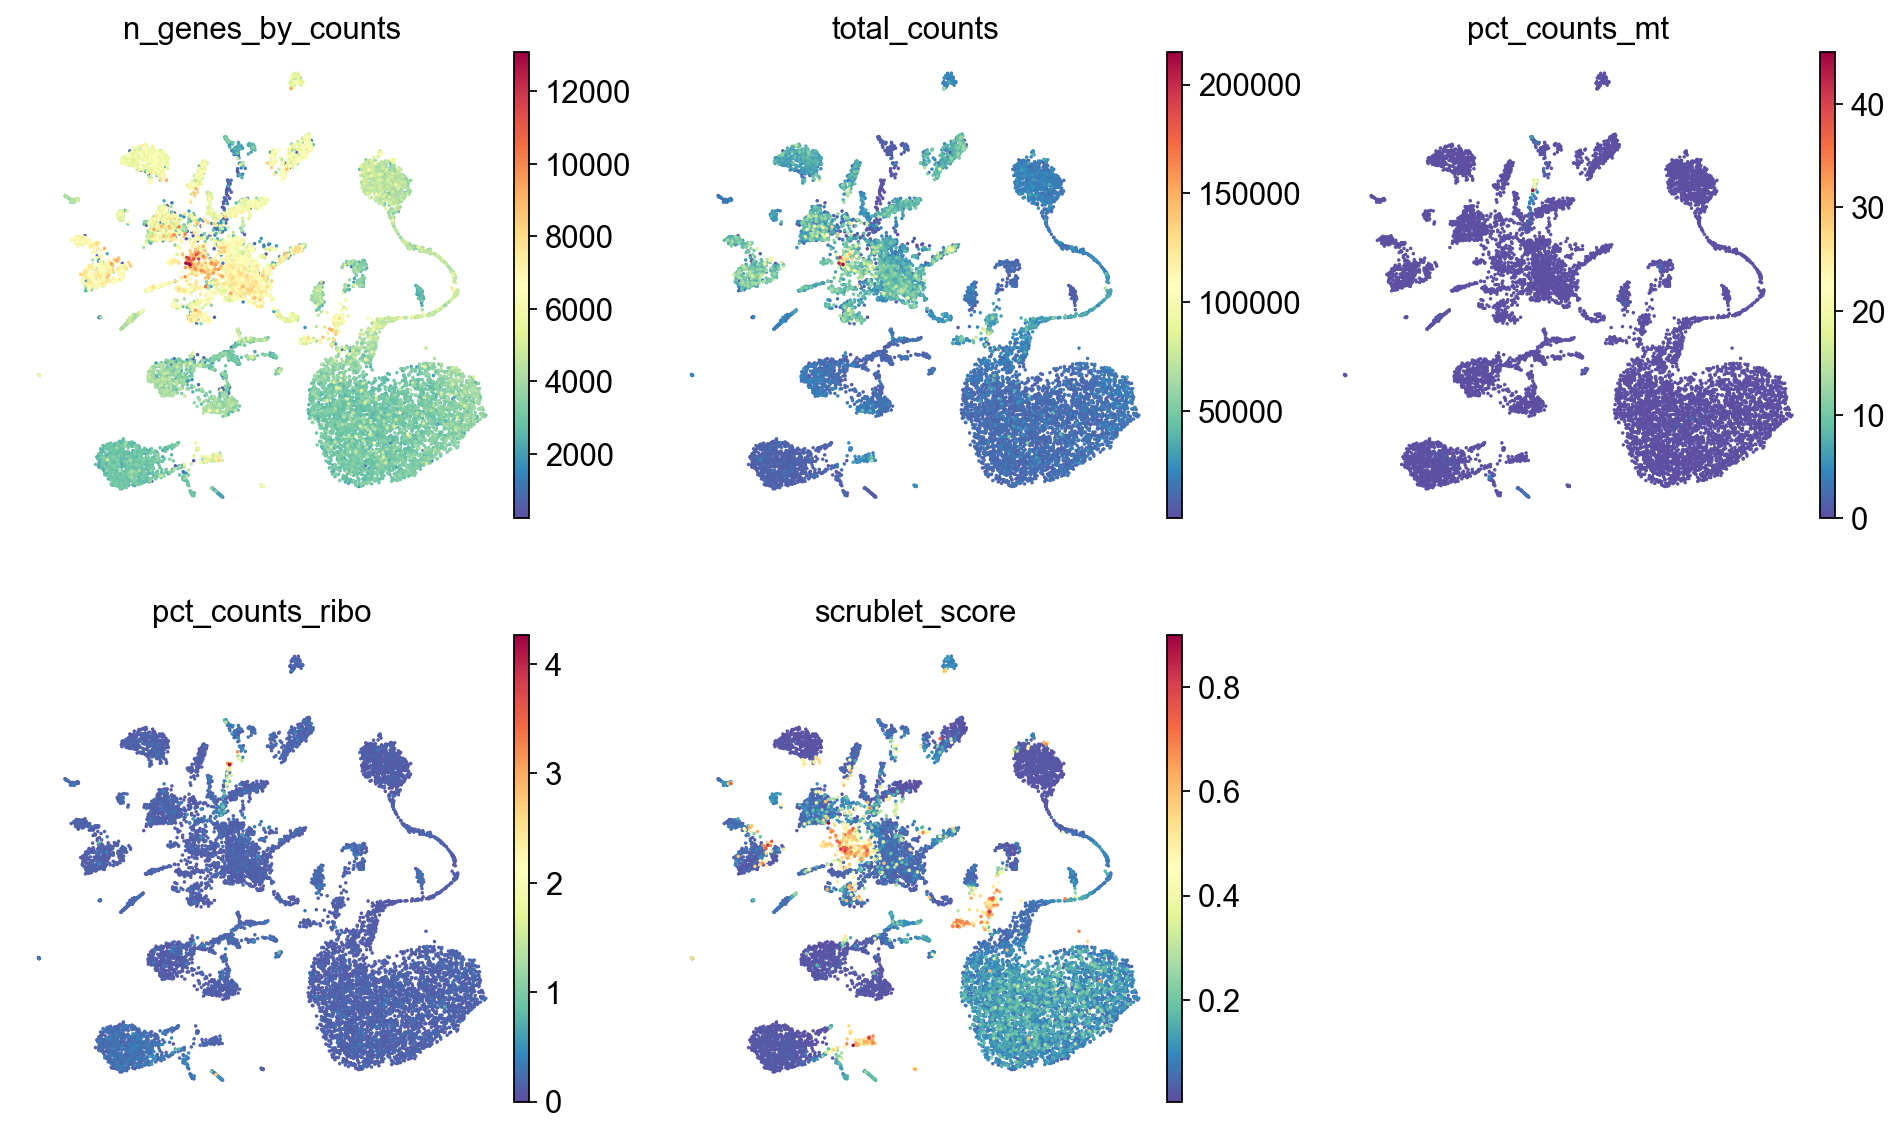

In [23]:
sc.pl.umap(adata,
           color=['n_genes_by_counts', 'total_counts','pct_counts_mt','pct_counts_ribo', 'scrublet_score'],
           cmap='Spectral_r',
           palette=piaso.pl.color.d_color1,
           ncols=3,
           size=10,
           frameon=False)

### Leiden clustering

In [24]:
%%time
sc.tl.leiden(adata,resolution=0.5,key_added='Leiden')

running Leiden clustering
    finished: found 33 clusters and added
    'Leiden', the cluster labels (adata.obs, categorical) (0:00:04)
CPU times: user 4.38 s, sys: 25.7 ms, total: 4.41 s
Wall time: 4.4 s


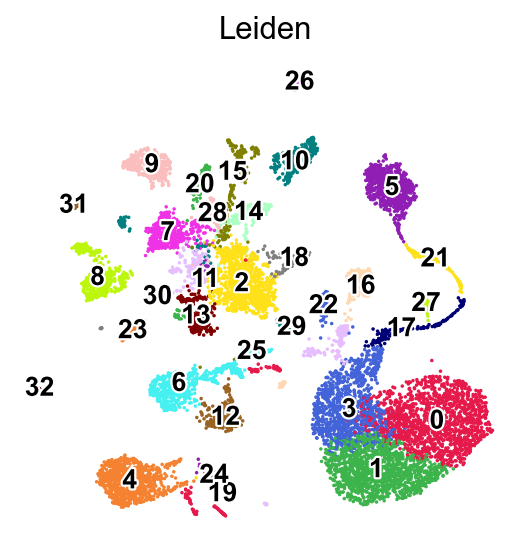

In [25]:
sc.pl.umap(adata,
           color=['Leiden'],
           palette=piaso.pl.color.d_color1,
           legend_fontsize=12,
           legend_fontoutline=2,
           legend_loc='on data',
           ncols=1,
           size=10,
           frameon=False)

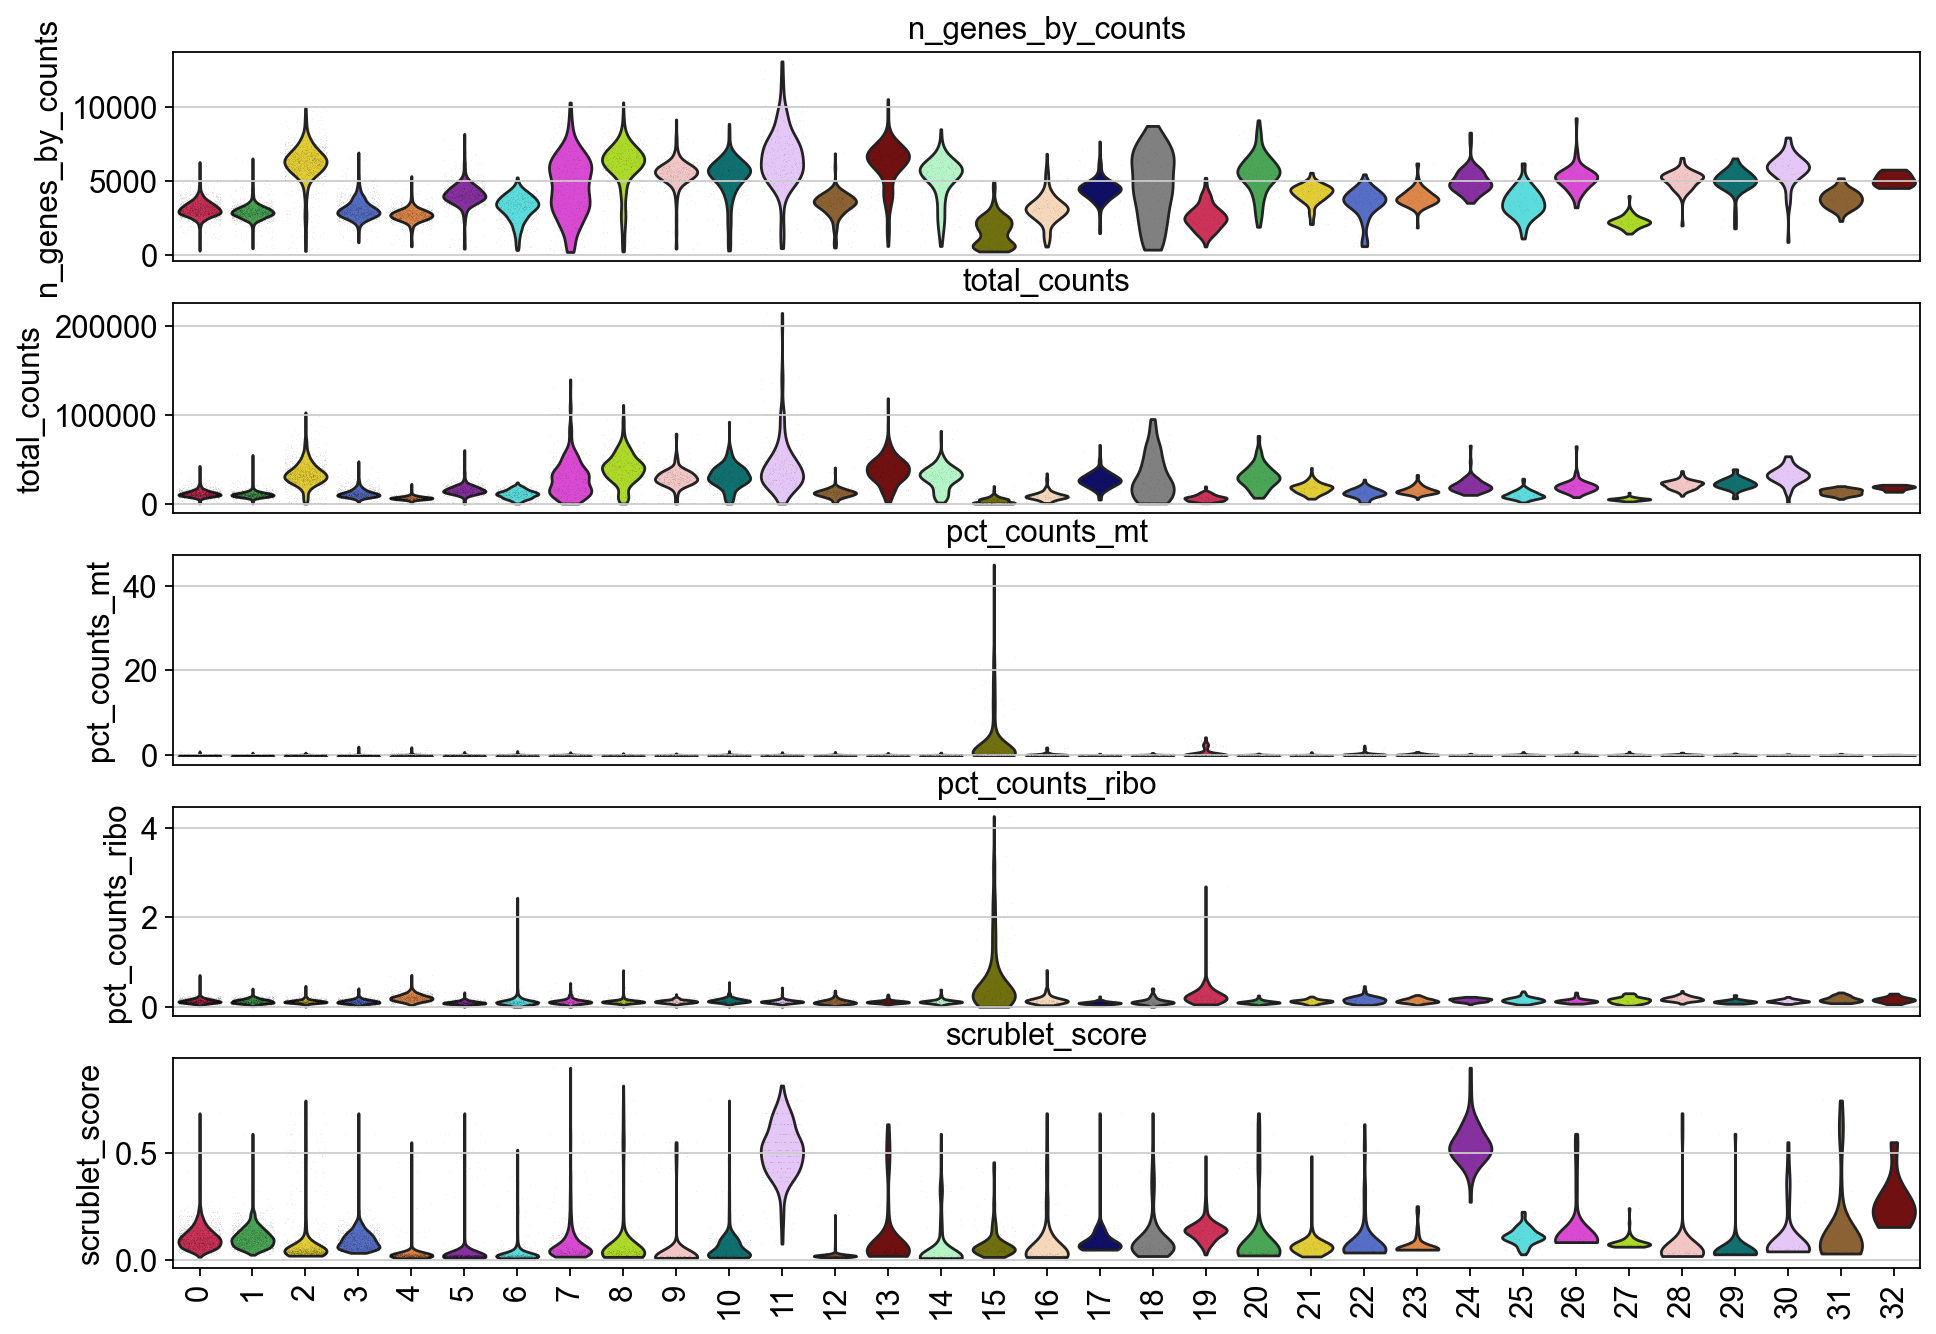

In [26]:
piaso.pl.plot_features_violin(adata,
                              ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'scrublet_score'],
                              groupby='Leiden')

#### Identify marker genes with COSG

In [27]:
%%time
n_gene=30
cosg.cosg(adata,
          key_added='cosg',
          use_raw=False,
          layer='log1p',
          mu=100,
          expressed_pct=0.1,
          remove_lowly_expressed=True,
          n_genes_user=100,
          groupby='Leiden')

CPU times: user 3.22 s, sys: 1.12 s, total: 4.34 s
Wall time: 4.34 s


Storing dendrogram info using `.uns['dendrogram_Leiden']`


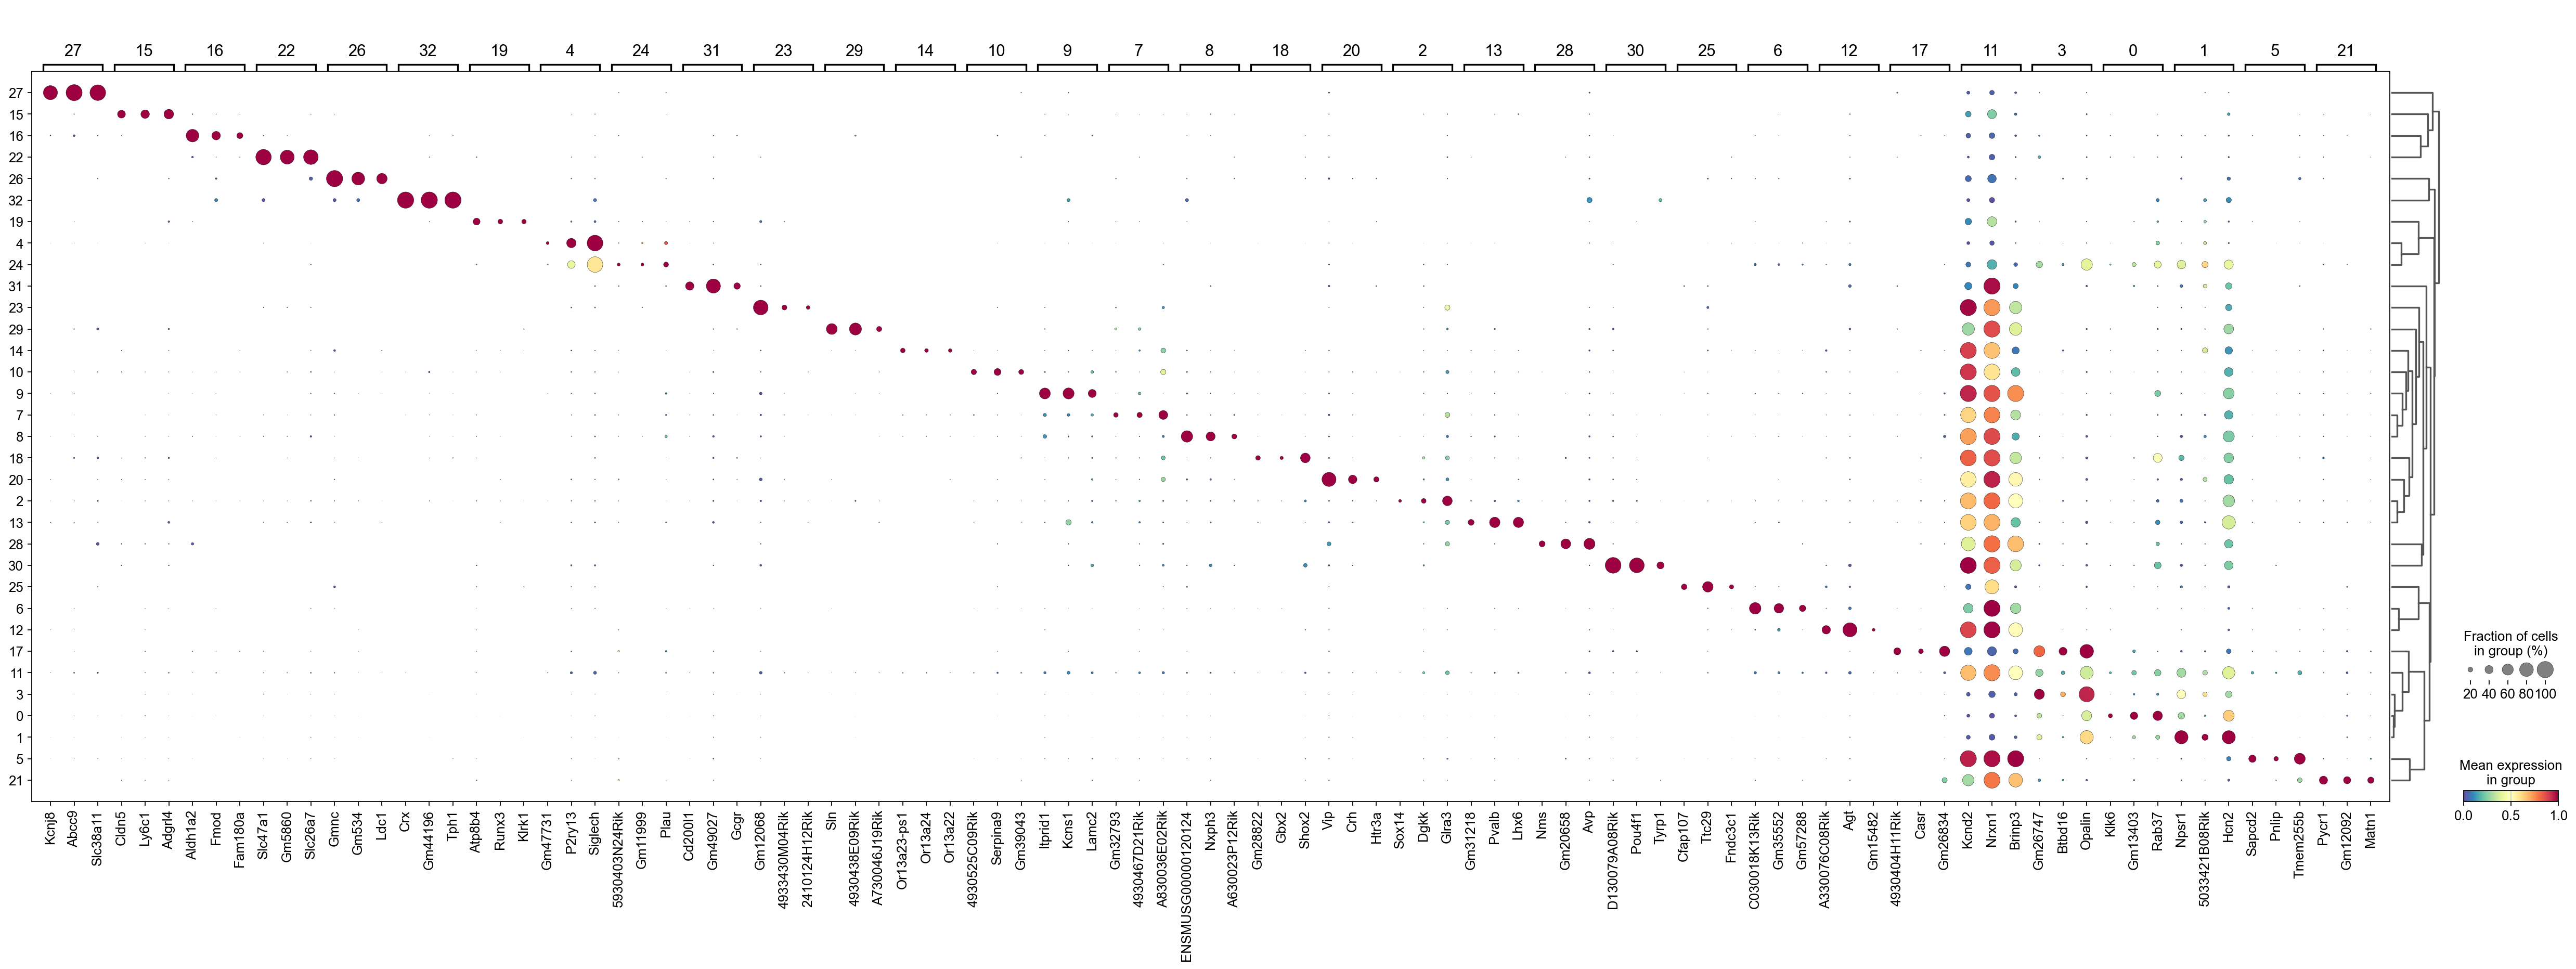

In [28]:
sc.tl.dendrogram(adata,groupby='Leiden',use_rep='X_svd')
df_tmp=pd.DataFrame(adata.uns['cosg']['names'][:3,]).T
df_tmp=df_tmp.reindex(adata.uns['dendrogram_'+'Leiden']['categories_ordered'])
marker_genes_list={idx: list(row.values) for idx, row in df_tmp.iterrows()}
marker_genes_list = {k: v for k, v in marker_genes_list.items() if not any(isinstance(x, float) for x in v)}

sc.pl.dotplot(adata,
              marker_genes_list,
              groupby='Leiden',
              layer='log1p',
              dendrogram=True,
              swap_axes=False,
              standard_scale='var',
              cmap='Spectral_r')

### Marker genes of an individual cluster

We can use dotplots and UMAPs to visualize the expression of the top marker genes in a selected cluster, which can be used to evaluate cluster quality.

In [29]:
marker_gene=pd.DataFrame(adata.uns['cosg']['names'])

In [30]:
cluster_check='8'
marker_gene[cluster_check].values

array(['ENSMUSG00000120124', 'Nxph3', 'A630023P12Rik', 'Trpv6', 'Gm27040',
       'Chrna5', 'Fezf2', '5330416C01Rik', 'Nlrp6', 'Tbata',
       '4930551E15Rik', 'Hs3st4', 'Krt80', 'Abi3bp', 'Gm35161', 'Gm15942',
       'B4galnt3', 'Gm17171', 'Htr1f', 'Rxfp1', 'Prss12', 'Tmem178',
       'Gm49422', 'Serinc2', 'Cwh43', 'Prss35', 'Gm11762', 'Gm13335',
       'Gm36736', 'Gm31308', 'Rprm', 'Ipcef1', 'Myl4', 'Ccn4', 'Hs3st2',
       'Hmga2', 'Hcrtr2', 'Galnt9', 'Col5a1', 'Nptx1', 'Sdk2', 'Sel1l3',
       'Slc16a10', 'Sv2b', 'Ephb6', 'A830018L16Rik', 'Trbc2', 'Mirt1',
       'Cpa6', 'Gm15270', 'Gm27234', 'Pcsk5', 'Hcrtr1', 'Rspo2',
       'Gm20878', 'Gm13391', 'Kcnmb4', 'Cdh18', 'Diras2', 'Adgra1',
       'Gm5468', 'Zmiz1os1', 'Khdrbs3', 'Rgsl1', 'Etl4', 'Serpinb8',
       'Gm17167', 'Gm12394', 'Gm9899', 'Garnl3', 'Ptpru', 'Scube2',
       'Slc17a7', 'Zdhhc23', 'Ano3', 'Tbr1', 'Grik3', 'Gm2824', 'Gm42056',
       'Vwc2l', 'Ccl27a', 'Gm35853', 'Sigmar1', 'Grp', 'Kcnmb4os2',
       'Pamr1', 'Gm4

The dot plot below displays the expression of the top marker genes from cluster 8 across all clusters. For cluster 8 to be considered high quality, its top marker genes should be primarily specific to cluster 8, showing little to no expression in other clusters.

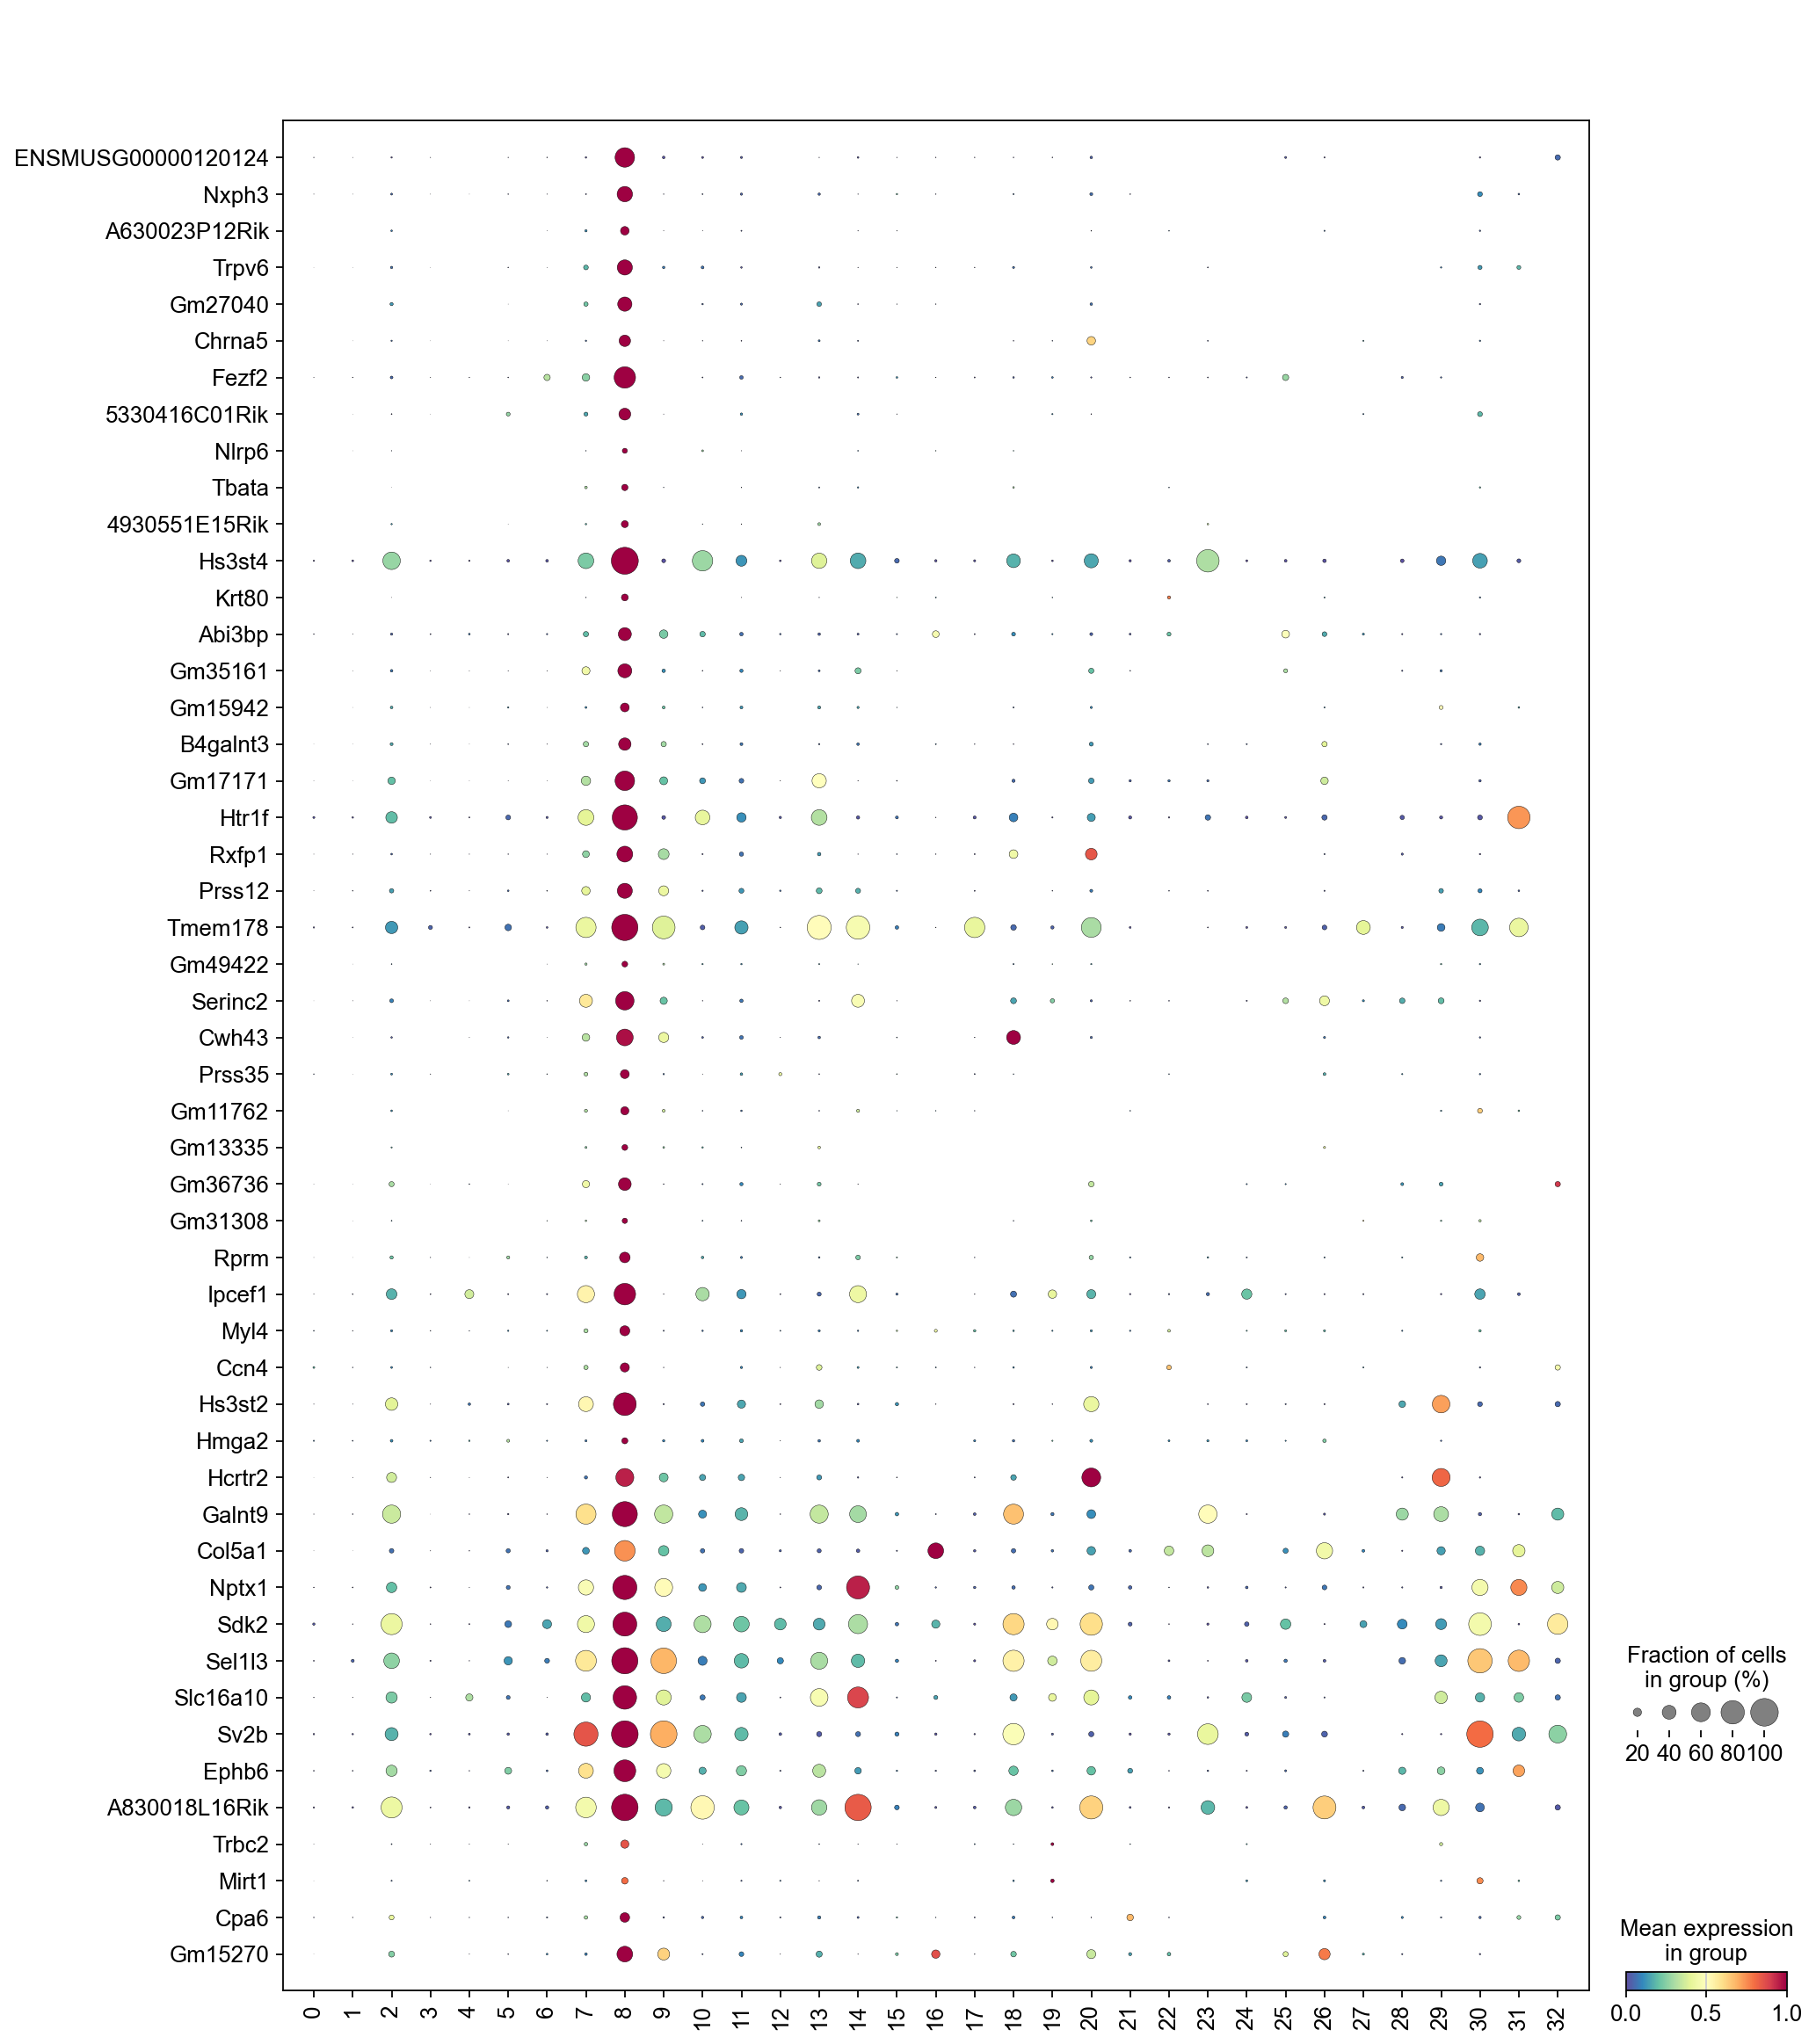

In [31]:
sc.pl.dotplot(adata,
              marker_gene[cluster_check].values[:50],
              groupby='Leiden',              
              dendrogram=False,
              swap_axes=True,
              standard_scale='var',
              cmap='Spectral_r')

We can visualize the expression of the top 12 genes from cluster 8 on UMAPs to assess whether their expression is specific to the cluster 8 region. This involves comparing the location of cluster 8 on the Leiden cluster UMAP with the gene expression UMAPs. In a high-quality cluster, marker gene expression should be predominantly localized to the cluster 8 area.

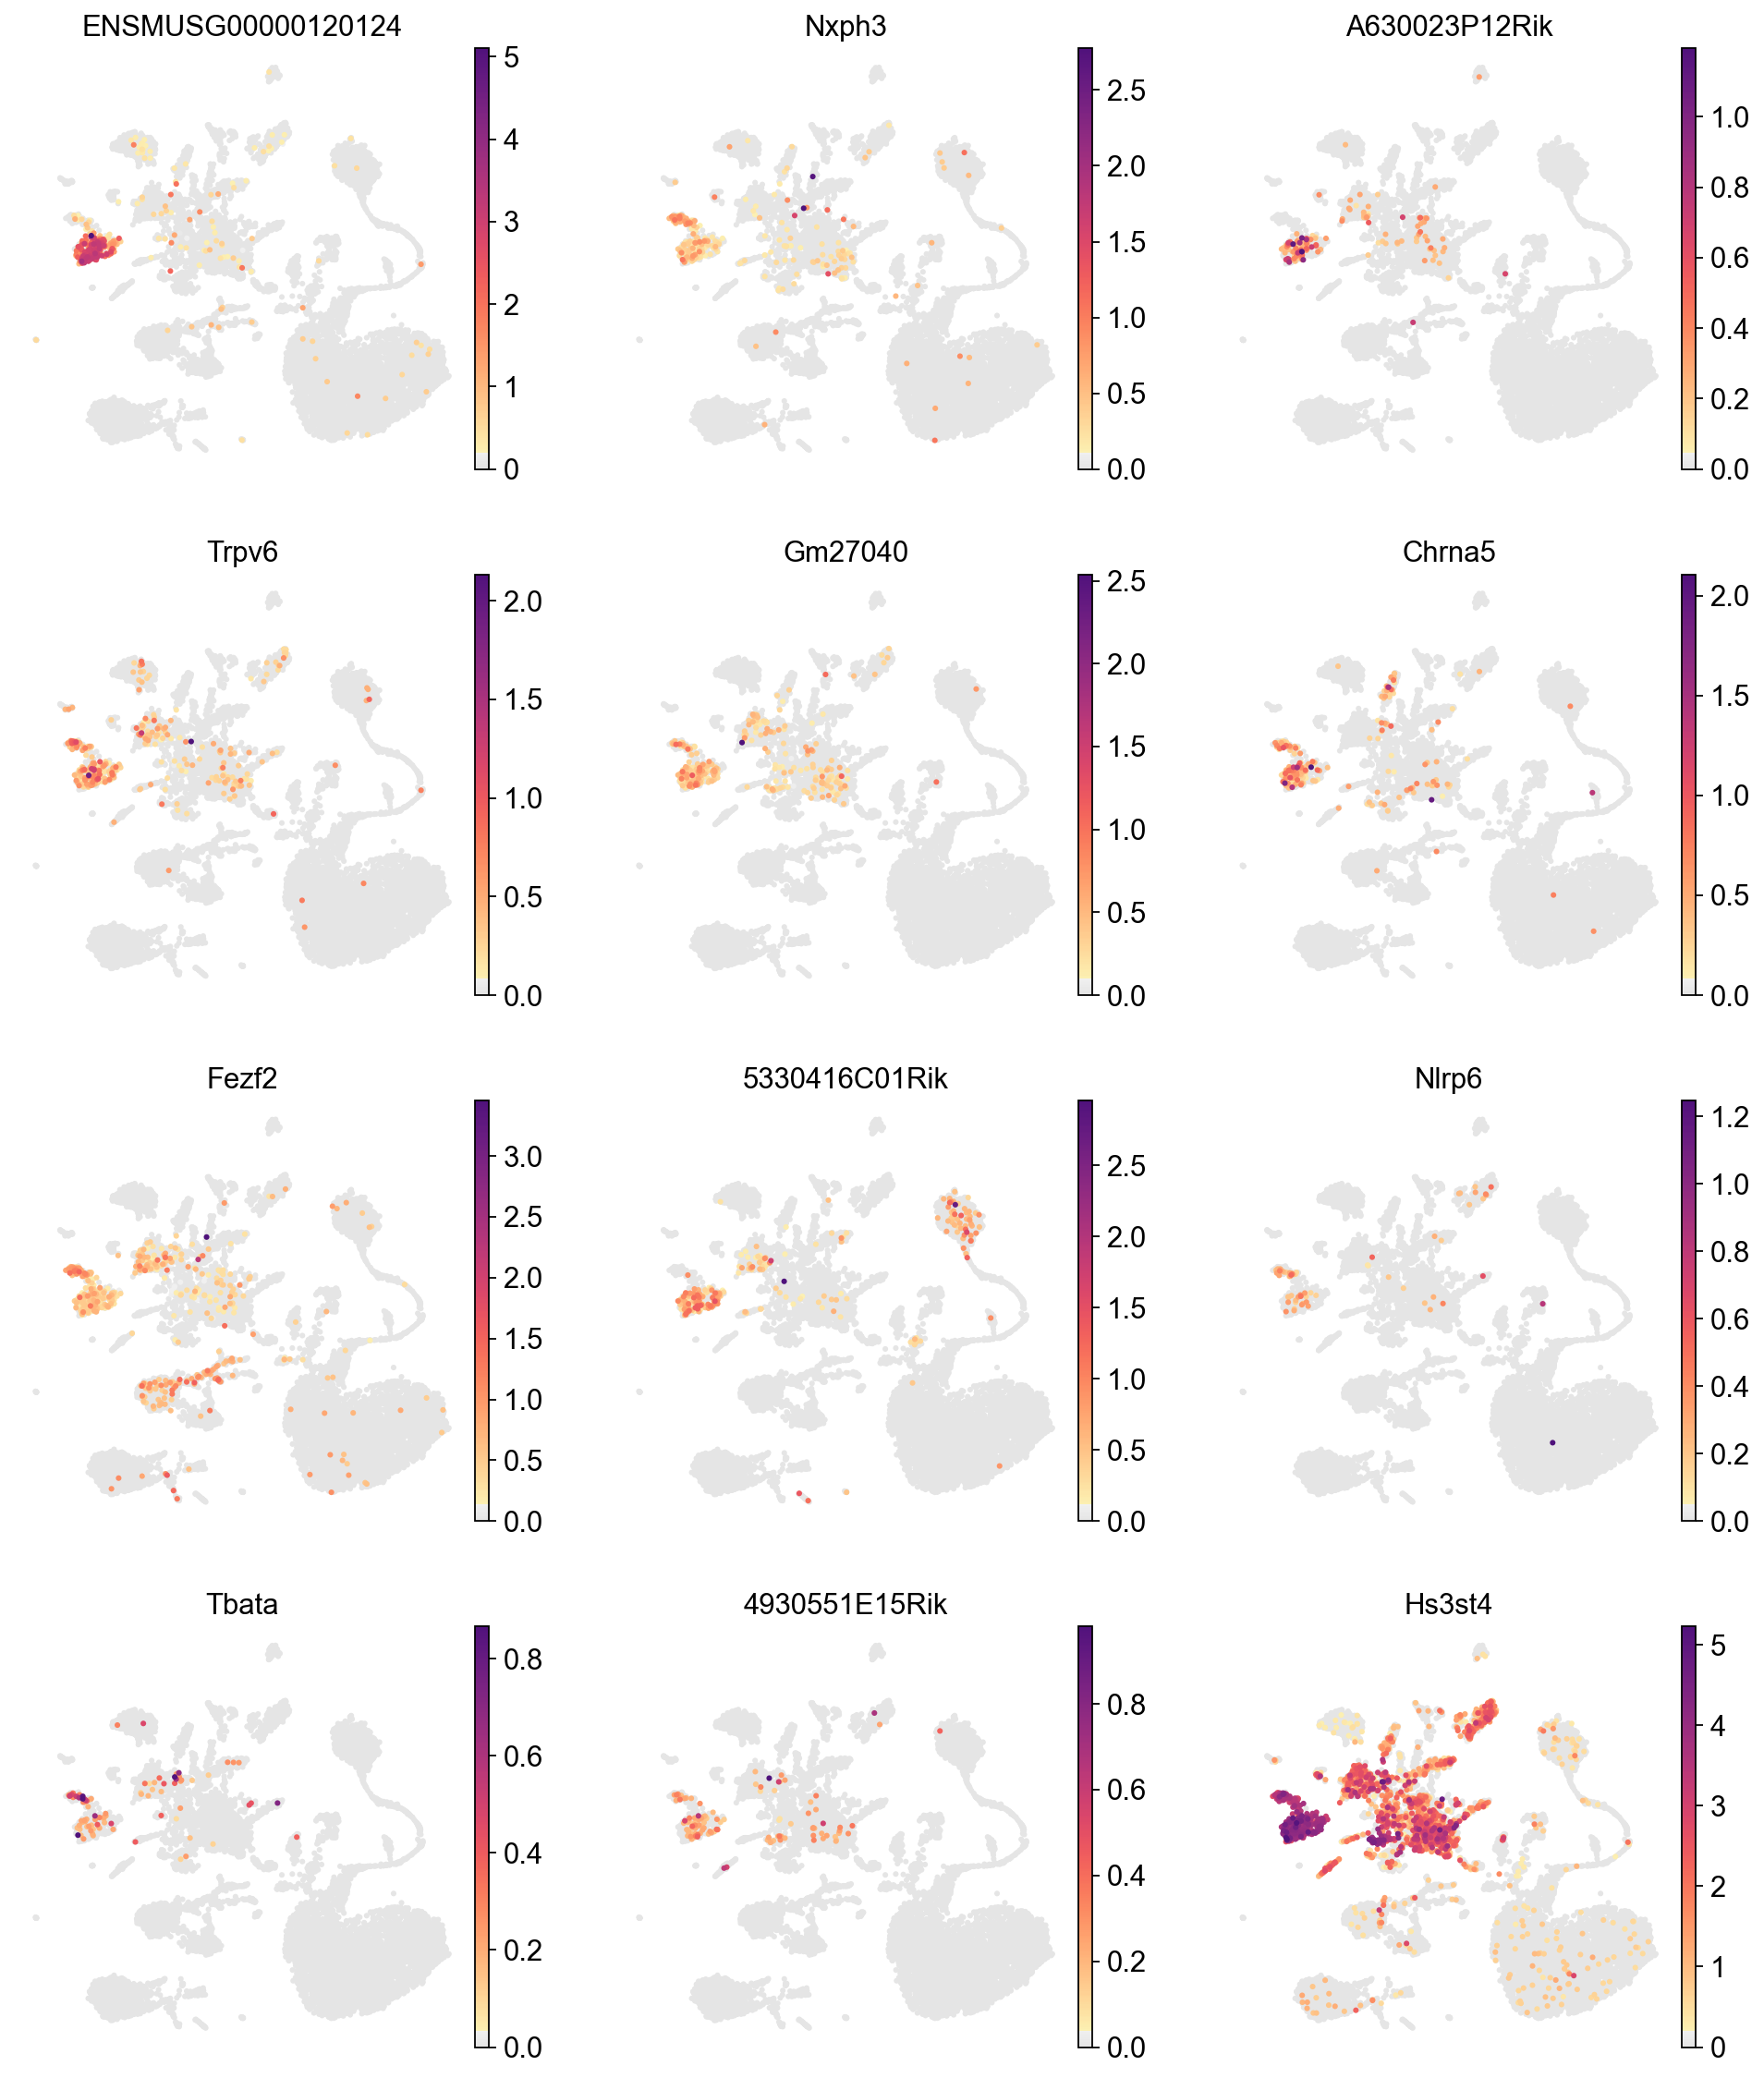

In [32]:
sc.pl.umap(adata,
           color=marker_gene[cluster_check][:12],
           palette=piaso.pl.color.d_color1,
           cmap=piaso.pl.color.c_color1,
           layer='log1p',
           legend_fontsize=12,
           legend_fontoutline=2,
           legend_loc='on data',
           ncols=3,
           size=30,
           frameon=False)

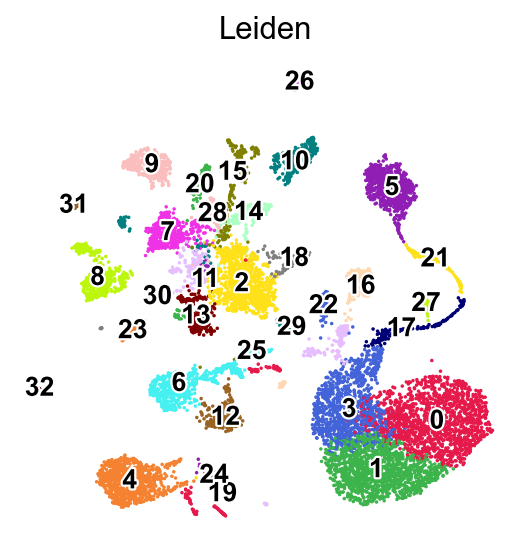

In [33]:
sc.pl.umap(adata,
           color=['Leiden'],
           palette=piaso.pl.color.d_color1,
           cmap=piaso.pl.color.c_color1,
           legend_fontsize=12,
           legend_fontoutline=2,
           legend_loc='on data',
           ncols=1,
           size=10,
           frameon=False)

This pipeline is still in development. The next steps include using a reference dataset to annotate cell types with PIASO's predictCellTypesByGDR, followed by multiple iterations of low-quality cluster removal and re-clustering until well-defined clusters are obtained.